# 0 - Présentation du sujet et mise en place du projet

Nous avons choisi de faire de la classification supervisé sur les panneaux routiers

In [1]:
pip install opendatasets

In [2]:
pip install opencv-python-headless

In [3]:
pip install tensorflow

In [4]:
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import random
import shutil
import tensorflow as tf
import joblib
from google.colab import files
from PIL import Image, ImageEnhance, ImageFilter
from google.colab.patches import cv2_imshow
from google.colab import files
from keras import layers, models
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

Informations pour importer le dataset :
  - username : pedrovanhylckama
  - key : 71b9da1af5b7f28a485d5ddba5f6f268



In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
# https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
# Clean old dataset if necessary
#shutil.rmtree('./gtsrb-german-traffic-sign')

# Download
od.download("https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign",force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pedrovanhylckama
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


100%|██████████| 612M/612M [00:18<00:00, 34.5MB/s]


## 1 - Préparation des données

Traitements possibles :
 - **Nettoyage**
    - *Valeurs manquantes* en s'assurant qu'il y ai pas de données/étiquettes manquantes
    - *Valeurs aberrantes* en s'assurant que toutes les étiquettes sont correctes
 - **Formatage des données**
    - *Format (ppm jpg csv)*
    - *Taille des images*
 - **Equilibrage des classes** (réduction ou *augmentation*), dans notre cas nous augmenterons les classes contenant moins d'images en appliquant les transformations suivantes :
    - Transformation photométrique (comme modification *contraste*, *saturation*, *couleur noir/blanc*)
    - Transformation par occlusion (masquage aléatoire de certaines parties de l'image pour simuler obstruction)
    - Transformation géométrique (comme rotation)
    - Transformation par réflexion (miroir horizontal, vertical), n'est pas pertinent, de plus, cela inverserait certaines classes (par exemple obligation d'aller à droite ou à gauche)
 - **Normalisation des données** (que nous n'appliquerons pas)
 - **Numérisation des colonnes** (que nous n'appliquerons pas)
 - **Traduction des données** (que nous n'appliquerons pas)




# Chargement des données

In [7]:
# Dossiers racine contenant les images
rootImageDirTrain = 'gtsrb-german-traffic-sign/Train'
rootImageDirValidation = 'gtsrb-german-traffic-sign/Meta'
rootImageDirTest = 'gtsrb-german-traffic-sign/Test'

In [8]:
data_train = pd.read_csv("gtsrb-german-traffic-sign/Train.csv")
data_test = pd.read_csv("gtsrb-german-traffic-sign/Test.csv")
data_meta = pd.read_csv("gtsrb-german-traffic-sign/Meta.csv")

# Trouver la taille de la plus petite classe
min_count = data_train['ClassId'].value_counts().min()

# Sélectionner min_count images par ClassId
data_train = data_train.groupby('ClassId').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

# Vérifier le résultat
print(data_train['ClassId'].value_counts())
print(data_train.shape)

# Reading csv heads
print(data_train.head(10))
print(data_test.head(10))
print(data_meta.head(10))

ClassId
0     210
1     210
2     210
3     210
4     210
5     210
6     210
7     210
8     210
9     210
10    210
11    210
12    210
13    210
14    210
15    210
16    210
17    210
18    210
19    210
20    210
21    210
22    210
23    210
24    210
25    210
26    210
27    210
28    210
29    210
30    210
31    210
32    210
33    210
34    210
35    210
36    210
37    210
38    210
39    210
40    210
41    210
42    210
Name: count, dtype: int64
(9030, 8)
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     29      30       6       6      24      25        0   
1     56      54       5       5      50      49        0   
2     69      70       7       6      63      64        0   
3     60      64       5       6      55      59        0   
4     27      26       6       5      22      21        0   
5     31      30       5       6      26      25        0   
6     38      38       5       6      32      33        0   
7     35      38       5       6      

 # Nettoyage des données

In [9]:
# Check null values
print(data_train.isnull().any())
print(data_test.isnull().any())
print(data_meta.isnull().any())

# Meta has a null value, we display it
print(data_meta[data_meta.isnull().any(axis=1)])

Width      False
Height     False
Roi.X1     False
Roi.Y1     False
Roi.X2     False
Roi.Y2     False
ClassId    False
Path       False
dtype: bool
Width      False
Height     False
Roi.X1     False
Roi.Y1     False
Roi.X2     False
Roi.Y2     False
ClassId    False
Path       False
dtype: bool
Path       False
ClassId    False
ShapeId    False
ColorId    False
SignId      True
dtype: bool
           Path  ClassId  ShapeId  ColorId SignId
24  Meta/30.png       30        0        0    NaN


In [10]:
# Lister toutes les images dans les dossiers
def listAllImages(root_dir,isTest):
    image_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.png'):
                if isTest:
                  image_paths.append(os.path.join(root.split("/")[1], file).replace('\\', '/'))
                else:
                  image_paths.append(os.path.join(root.split("/")[1]+"/"+os.path.basename(root)+"/", file).replace('\\', '/'))
    return image_paths

# Vérifier que chaque image dans le dossier est étiquetée
def checkAllImagesLabeled(image_paths, labeled_paths):
    unlabeled_images = []
    labeled_set = set(labeled_paths)
    for image_path in image_paths:
        if image_path not in labeled_set:
            unlabeled_images.append(image_path)
    return unlabeled_images

def areImagesLabeled(root_dir, dataset, isTest=False):
    # Obtenir la liste de toutes les images dans les dossiers
    all_image_paths = listAllImages(root_dir,isTest)
    # Obtenir la liste des chemins d'images dans le fichier CSV
    csv_image_paths = dataset['Path'].tolist()
    # Vérifier les images non étiquetées
    unlabeled_images = checkAllImagesLabeled(all_image_paths, csv_image_paths)
    # Afficher les résultats
    if len(unlabeled_images) == 0:
        print("Toutes les images dans les dossiers sont bien étiquetées.")
    else:
        print("Les images suivantes ne sont pas étiquetées :")
        for img in unlabeled_images:
            print(img)

print("Train :")
areImagesLabeled(rootImageDirTrain, dataset=data_train)
print("Test :")
areImagesLabeled(rootImageDirTest, dataset=data_test, isTest=True)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Train/3/00003_00030_00004.png
Train/3/00003_00006_00000.png
Train/3/00003_00021_00022.png
Train/3/00003_00005_00024.png
Train/3/00003_00000_00025.png
Train/3/00003_00021_00012.png
Train/3/00003_00037_00000.png
Train/3/00003_00021_00018.png
Train/3/00003_00032_00004.png
Train/3/00003_00016_00017.png
Train/3/00003_00003_00010.png
Train/3/00003_00004_00018.png
Train/3/00003_00026_00025.png
Train/3/00003_00016_00008.png
Train/3/00003_00025_00009.png
Train/3/00003_00028_00013.png
Train/3/00003_00027_00000.png
Train/3/00003_00023_00012.png
Train/3/00003_00028_00020.png
Train/3/00003_00043_00006.png
Train/3/00003_00017_00029.png
Train/3/00003_00000_00009.png
Train/3/00003_00017_00015.png
Train/3/00003_00018_00007.png
Train/3/00003_00014_00021.png
Train/3/00003_00004_00025.png
Train/3/00003_00022_00028.png
Train/3/00003_00039_00012.png
Train/3/00003_00030_00010.png
Train/3/00003_00023_00027.png
Train/3/00003_00017_00

# Transformations appliquées aux images (B&L, Rotation, Saturation...) avec resize

In [11]:
# Resize des images initiales en modifiant les images du dossier et en mettant à jour le csv
# Nous pourrions exécuter cette fonction dès le début cependant cela est assez long
# Pour aller plus vite, nous effectuons le resize lors de la transformation
# sans changer les images dans le dossier
# Les images transformées seront donc directement enregistrées dans nos vecteurs de données
# Et les lignes correspondantes aux nouvelles images seront ajoutées dans le fichier csv

"""
def resize_and_update_csv(path_list, csv_path):
    # Lire le CSV
    df = pd.read_csv(csv_path)

    for p in path_list:
        image_path = os.path.join('gtsrb-german-traffic-sign', p)  # Utiliser le chemin complet de l'image
        print(f"Traitement de l'image : {image_path}")  # Impression pour débogage
        if os.path.exists(image_path):
            try:
                image = Image.open(image_path)
                new_size = (50, 50)
                resized_image = image.resize(new_size, Image.LANCZOS)

                # Sauvegarder l'image redimensionnée en écrasant l'image d'origine
                resized_image.save(image_path)

                # Mettre à jour les dimensions dans le CSV
                relative_path = p  # Utiliser le chemin relatif directement
                df.loc[df['Path'] == relative_path, 'Width'] = new_size[0]
                df.loc[df['Path'] == relative_path, 'Height'] = new_size[1]
            except Exception as e:
                print(f"Erreur lors du traitement de l'image {image_path}: {e}")
        else:
            print(f"Fichier introuvable : {image_path}")

    # Sauvegarder le CSV mis à jour
    df.to_csv(csv_path, index=False)

# Obtenir les chemins des images à redimensionner
def get_image_paths_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    image_paths = df['Path'].tolist()
    return image_paths, df

# Pour chaque dossier on a les trois étapes suivantes
# Chemin vers le fichier CSV et le dossier racine des images
# Charger les chemins des images
# Appliquer la fonction de redimensionnement et mettre à jour le CSV

csv_path_train = 'gtsrb-german-traffic-sign/Train.csv'
image_paths_train, df_train = get_image_paths_from_csv(csv_path_train)
resize_and_update_csv(image_paths_train, csv_path_train)

csv_path_test = 'gtsrb-german-traffic-sign/Test.csv'
image_paths_test, df_test = get_image_paths_from_csv(csv_path_test)
resize_and_update_csv(image_paths_test, csv_path_test)

csv_path_meta = 'gtsrb-german-traffic-sign/Meta.csv'
image_paths_meta, df_meta = get_image_paths_from_csv(csv_path_meta)
resize_and_update_csv(image_paths_meta, csv_path_meta)
"""

'\ndef resize_and_update_csv(path_list, csv_path):\n    # Lire le CSV\n    df = pd.read_csv(csv_path)\n\n    for p in path_list:\n        image_path = os.path.join(\'gtsrb-german-traffic-sign\', p)  # Utiliser le chemin complet de l\'image\n        print(f"Traitement de l\'image : {image_path}")  # Impression pour débogage\n        if os.path.exists(image_path):\n            try:\n                image = Image.open(image_path)\n                new_size = (50, 50)\n                resized_image = image.resize(new_size, Image.LANCZOS)\n\n                # Sauvegarder l\'image redimensionnée en écrasant l\'image d\'origine\n                resized_image.save(image_path)\n\n                # Mettre à jour les dimensions dans le CSV\n                relative_path = p  # Utiliser le chemin relatif directement\n                df.loc[df[\'Path\'] == relative_path, \'Width\'] = new_size[0]\n                df.loc[df[\'Path\'] == relative_path, \'Height\'] = new_size[1]\n            except Exce

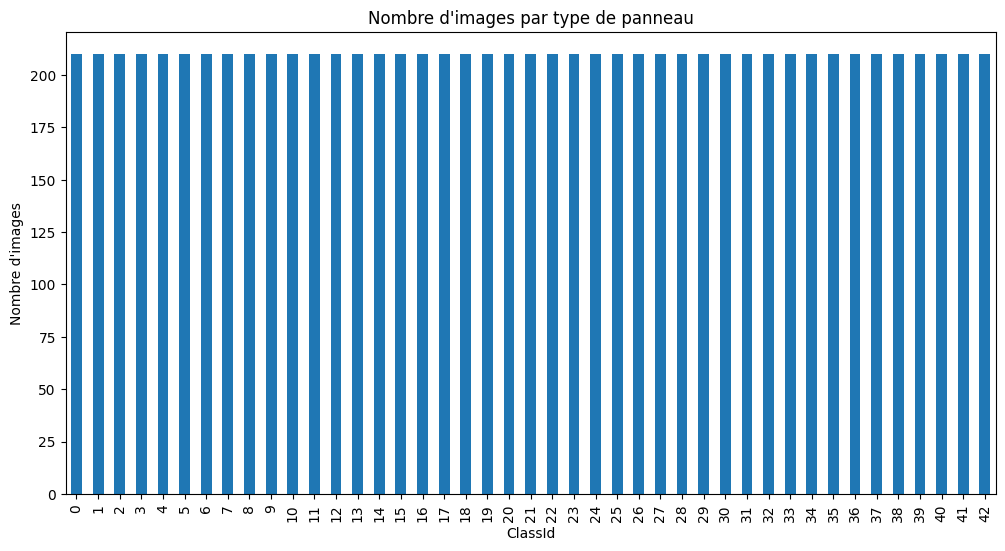

In [12]:
# Count image number for each classId
compte_classid = data_train['ClassId'].value_counts()

# Display results in graph
plt.figure(figsize=(12, 6))
compte_classid.sort_index().plot(kind='bar')
plt.xlabel('ClassId')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par type de panneau')
plt.xticks(rotation=90)
plt.show()

In [13]:
def addLineToDataFrame(path, classId):
  global data_train
  new_line = pd.DataFrame({"Width":50, "Height":50, "Roi.X1":0, "Roi.Y1":0,"Roi.X2":0,"Roi.Y2":0, "ClassId":classId, "Path":path}, index=[0])
  data_train = pd.concat([data_train, new_line], ignore_index=True)


In [14]:
def blackAndWhiteImage(path, dataset, datasetPath, classId, last=True):
  # Load image
  image = Image.open(path)

  # Convert to b&l
  image_bl = image.convert('L')

  # Add new label to image
  path_bl = path[path.find("Train"):]
  path_bl = path_bl.split(".")[0] + '_bw.png'
  #addLineToCsv(dataset, datasetPath, path, path_bl)
  if(last):
    addLineToDataFrame(path_bl, classId)
  # Save duplicate
  image_bl.save('gtsrb-german-traffic-sign/' + path_bl)

  return 'gtsrb-german-traffic-sign/' + path_bl

In [15]:
def saturateImage(path, dataset, datasetPath, classId, last=True, saturation_factor=2):
    # Load image
    image = Image.open(path)
    # Apply saturation
    enhancer = ImageEnhance.Color(image)
    image_sat = enhancer.enhance(saturation_factor)
    # Save duplicate
    path_sat = path[path.find("Train"):]
    path_sat = path_sat.split(".")[0] + '_sat.png'
    #addLineToCsv(dataset, datasetPath, path, path_sat)
    if(last):
      addLineToDataFrame(path_sat, classId)
    image_sat.save('gtsrb-german-traffic-sign/' + path_sat)

    return 'gtsrb-german-traffic-sign/' + path_sat

In [16]:
def blurImage(path, dataset, datasetPath, classId, last=True, radius=0.8):
    # Load image
    image = Image.open(path)
    # Apply blur
    blurred_image = image.filter(ImageFilter.GaussianBlur(radius))
    # Save duplicate
    path_blurred = path[path.find("Train"):]
    path_blurred = path_blurred.split(".")[0] + '_blur.png'
    #addLineToCsv(dataset, datasetPath, path, path_blurred)
    if(last):
      addLineToDataFrame(path_blurred, classId)
    blurred_image.save('gtsrb-german-traffic-sign/' + path_blurred)

    return 'gtsrb-german-traffic-sign/' + path_blurred


In [17]:
def obstructImage(path, dataset, datasetPath, classId, last=True, mask_size_ratio=0.1):
    # Load image
    image = cv2.imread(path)
    h, w, _ = image.shape
    mask_h, mask_w = int(h * mask_size_ratio), int(w * mask_size_ratio)
    # Randomly choose a position for the mask
    x = np.random.randint(0, w - mask_w)
    y = np.random.randint(0, h - mask_h)
    # Apply the mask
    image[y:y+mask_h, x:x+mask_w] = 0  # Black square
    # Save duplicate
    path_obstructed = path[path.find("Train"):]
    path_obstructed = path_obstructed.split(".")[0] + '_obs.png'
    #addLineToCsv(dataset, datasetPath, path, path_obstructed)
    if(last):
      addLineToDataFrame(path_obstructed, classId)
    cv2.imwrite('gtsrb-german-traffic-sign/' + path_obstructed, image)

    return 'gtsrb-german-traffic-sign/' + path_obstructed

In [18]:
def rotateImage(path, dataset, datasetPath, classId, last=True, angle_range=(-30, 30)):
    # Load image
    image = Image.open(path)
    # Randomly choose an angle
    angle = np.random.uniform(angle_range[0], angle_range[1])
    # Apply rotation
    rotated_image = image.rotate(angle, resample=Image.BICUBIC, expand=True)
    # Save duplicate
    path_rotated = path[path.find("Train"):]
    path_rotated = path_rotated.split(".")[0] + '_rot.png'
    #addLineToCsv(dataset, datasetPath, path, path_rotated)
    if(last):
      addLineToDataFrame(path_rotated, classId)
    rotated_image.save('gtsrb-german-traffic-sign/' + path_rotated)

    return 'gtsrb-german-traffic-sign/' + path_rotated

In [19]:
def applytransform(path, index, classId):
  match(index%15):
    case 0:
      blackAndWhiteImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 1:
      blurImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 2:
      saturateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 3:
      obstructImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 4:
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 5:
      path = blackAndWhiteImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      blurImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 6:
      path = blackAndWhiteImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 7:
      path = blackAndWhiteImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      obstructImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 8:
      path = blurImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 9:
      path = blurImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      obstructImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 10:
      path = saturateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 11:
      path = saturateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      obstructImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 12:
      path = obstructImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 13:
      path = blackAndWhiteImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      path = blurImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 14:
      pass

In [20]:
def transformClasses():
    taille = len(data_train)
    for i in range(0, taille):
        imagePath = 'gtsrb-german-traffic-sign/' + data_train.iloc[i]['Path']
        #print(imagePath)
        applytransform(imagePath, i, data_train.iloc[i]["ClassId"])

In [21]:
print(data_train.tail(10))

      Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
9020     56      58       5       5      51      53       42   
9021     28      27       6       5      23      22       42   
9022     37      36       5       5      32      31       42   
9023    105      99      10       9      96      91       42   
9024     45      46       5       5      40      41       42   
9025     49      49       6       5      44      44       42   
9026     50      50       6       5      44      44       42   
9027     87      85       7       8      80      78       42   
9028     46      46       5       5      41      41       42   
9029     29      29       5       5      24      24       42   

                                Path  
9020  Train/42/00042_00007_00026.png  
9021  Train/42/00042_00007_00001.png  
9022  Train/42/00042_00005_00019.png  
9023  Train/42/00042_00001_00028.png  
9024  Train/42/00042_00001_00018.png  
9025  Train/42/00042_00002_00028.png  
9026  Train/42/00042_0

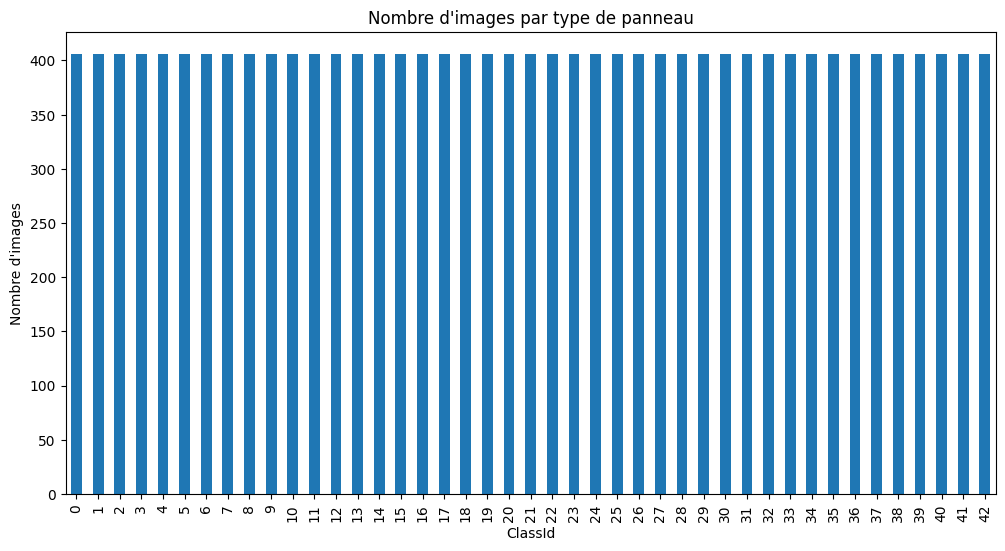

In [22]:
transformClasses()

# Count image number for each classId
compte_classid = data_train['ClassId'].value_counts()

# Display results in graph
plt.figure(figsize=(12, 6))
compte_classid.sort_index().plot(kind='bar')

plt.xlabel('ClassId')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par type de panneau')
plt.xticks(rotation=90)
plt.show()

In [23]:
def createTrainData():
    image_data = []
    image_labels = []

    data_list = list(data_train)
    for index, row in data_train.iterrows():
      try:
        path = row['Path']
        image = cv2.imread("gtsrb-german-traffic-sign/" + path)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((50, 50))
        image_data.append(np.array(resize_image))
        image_labels.append(row["ClassId"])

      except:
            print("Error in " + str(index))

    # Changing the list to numpy array
    image_data = np.array(image_data)
    image_labels = np.array(image_labels)

    shuffle_indexes = np.arange(image_data.shape[0])
    np.random.shuffle(shuffle_indexes)
    image_data = image_data[shuffle_indexes]
    image_labels = image_labels[shuffle_indexes]

    X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

    X_train = X_train/255
    X_val = X_val/255

    return X_train, y_train, X_val, y_val

In [24]:
X_train, y_train, X_val, y_val = createTrainData()
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (12220, 50, 50, 3)
X_valid.shape (5238, 50, 50, 3)
y_train.shape (12220,)
y_valid.shape (5238,)


# 2 - Réduction de dimension.

Nous pourrons utiliser la PCA, comme ci dessous, cependant nous verrons que les résultats avec cette dernière sont assez mauvais.
L'autre possibilité que nous avons utilisé est le fait d'utiliser les features suites au pooling effectué dans notre CNN qui permet bien de réduire nos dimensions.

In [ ]:
class PCAReductor():
    def __init__(self, n, x_train):
        self.n_comp = n
        self.pca = PCA(n_components=self.n_comp)
        self.images = np.copy(x_train)

    def pca_reduction(self):
        self.images = self.images.reshape(self.images.shape[0],3*50*50)
        self.pca.fit(self.images)
        print("fitting pca...")
        self.img_transformed = self.pca.transform(self.images)
        return self.img_transformed

    def plot_var(self):
        # Variance expliquée par chaque composante principale
        explained_variance = self.pca.explained_variance_ratio_

        # Visualisation de la variance expliquée
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(explained_variance))
        plt.xlabel('Nombre de composantes')
        plt.ylabel('Variance expliquée cumulée')
        plt.title('Variance expliquée par PCA')
        plt.show()

    def reconstruct_image(self, image, index):

        images_reconstructed = self.pca.inverse_transform(self.img_transformed)
        images_reconstructed = images_reconstructed.reshape(-1, 50, 50, 3)

        plt.figure(figsize=(12, 6))

        # Image originale
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image originale')

        # Image reconstruite
        plt.subplot(1, 2, 2)
        plt.imshow(images_reconstructed[index])
        plt.title('Image reconstruite')

        plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

# Image originale
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title('Image originale')
plt.show()

print(type(X_train))
print(type(X_val))

In [ ]:
pca = PCAReductor(7500,X_train)
X_train_pca = pca.pca_reduction()
pca.reconstruct_image(X_train[0], 0)
pca.plot_var()

In [ ]:
print(X_train_pca.shape)
print(X_train.shape)

# 3 - Utilisation de trois modèles.

Précision de la stratégie de validation utilisée  (pour cela nous nous sommes basés sur les chapitres 2&3).

Nous implémenterons les trois modèles suivants :
- *CNN*
- *Random Forest*
- *SVM*


In [25]:
# Création données test
def createTestData():
    test = data_test
    y_test = test["ClassId"].values
    imgs = test["Path"].values
    data =[]

    for img in imgs:
        try:
            image = cv2.imread('gtsrb-german-traffic-sign' + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((50, 50))
            data.append(np.array(resize_image))
        except:
            print("Error in " + img)

    X_test = np.array(data)
    X_test = X_test/255

    return X_test, y_test


In [26]:
X_test, y_test = createTestData()
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_test.shape (12630, 50, 50, 3)
y_test.shape (12630,)


In [ ]:
pca = PCAReductor(200, X_test)
X_test_pca = pca.pca_reduction()


In [27]:
#CNN

def create_simple_cnn(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (50, 50, 3)  # Adapter en fonction de tes données
num_classes = 43  # Nombre de classes de panneaux routiers
cnn_model = create_simple_cnn(input_shape, num_classes)

prediction = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
cnn_model.evaluate(X_test, y_test)

# Prédire les classes pour les données de test
y_pred_cnn = cnn_model.predict(X_test)
# Convertir les prédictions en classes
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Calculer l'exactitude
accuracy_cnn = accuracy_score(y_test, y_pred_cnn_classes)
print(f'CNN Accuracy: {accuracy_cnn}')

Epoch 1/10
382/382 [==============================] - 8s 9ms/step - loss: 1.9604 - accuracy: 0.4809 - val_loss: 0.7751 - val_accuracy: 0.7925
Epoch 2/10
382/382 [==============================] - 3s 7ms/step - loss: 0.5303 - accuracy: 0.8557 - val_loss: 0.4374 - val_accuracy: 0.8795
Epoch 3/10
382/382 [==============================] - 3s 7ms/step - loss: 0.2587 - accuracy: 0.9285 - val_loss: 0.3591 - val_accuracy: 0.9017
Epoch 4/10
382/382 [==============================] - 3s 8ms/step - loss: 0.1402 - accuracy: 0.9587 - val_loss: 0.2882 - val_accuracy: 0.9263
Epoch 5/10
382/382 [==============================] - 3s 7ms/step - loss: 0.0932 - accuracy: 0.9731 - val_loss: 0.2696 - val_accuracy: 0.9345
Epoch 6/10
382/382 [==============================] - 2s 6ms/step - loss: 0.0663 - accuracy: 0.9803 - val_loss: 0.2537 - val_accuracy: 0.9353
Epoch 7/10
382/382 [==============================] - 3s 7ms/step - loss: 0.0524 - accuracy: 0.9845 - val_loss: 0.3077 - val_accuracy: 0.9381
Epoch 

In [28]:
# Récupérer les features d'entrainement et de tests de la cnn (suite au pooling)
layer_name = 'dense'
intermediate_layer_model = Model(inputs=cnn_model.input,
                                 outputs=cnn_model.get_layer(layer_name).output)
train_features = intermediate_layer_model.predict(X_train)
test_features = intermediate_layer_model.predict(X_test)



395/395 [==============================] - 2s 5ms/step


In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf_model.fit(X_train_flat, y_train)
y_pred_rf = rf_model.predict(X_test_flat)

# Calculer l'exactitude
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

In [29]:
# Random Forest with feature extraction
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_flat_feature = train_features.reshape(X_train.shape[0], -1)
X_test_flat_feature = test_features.reshape(X_test.shape[0], -1)

rf_model.fit(X_train_flat_feature, y_train)
y_pred_rf = rf_model.predict(X_test_flat_feature)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

Random Forest Accuracy: 0.921298495645289


In [ ]:
# Random Forest with PCA # julian
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_flat = X_train_pca.reshape(X_train_pca.shape[0], -1)
X_test_flat = X_test_pca.reshape(X_test_pca.shape[0], -1)

rf_model.fit(X_train_flat, y_train)
y_pred_rf = rf_model.predict(X_test_flat)

# Calculer l'exactitude
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

In [ ]:
#SVM
svm_model = SVC(kernel='linear', C=1.0, probability=True)

svm_model.fit(X_train_flat, y_train)
y_pred_svm = svm_model.predict(X_test_flat)

# Calculer l'exactitude
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm}')


In [33]:
#SVM with feature extraction
svm_model = SVC(kernel='linear', C=1.0, probability=True)
svm_model.fit(X_train_flat_feature, y_train)
y_pred_svm = svm_model.predict(X_test_flat_feature)

# Calculer l'exactitude
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm}')


SVM Accuracy: 0.9263657957244655


In [34]:
# Sauvegarder et télécharger les modèles entraînés

# CNN
#joblib.dump(cnn_model, 'model_CNN.pkl')
#files.download('model_CNN.pkl')
#cnn_model.save('model_CNN.keras')
#files.download('model_CNN.keras')
cnn_model.save('model_CNN.h5')
files.download('model_CNN.h5')
# Random Forest
joblib.dump(rf_model, 'model_Random_Forest.pkl')
files.download('model_Random_Forest.pkl')
# SVM
joblib.dump(svm_model, 'model_SVM.pkl')
files.download('model_SVM.pkl')

print("Saved models to disk")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved models to disk


# 4 - Evaluation des modèles (via des métriques de validation adéquates)

Nous pourrons faire une *matrice de confusion* (pour cela nous nous sommes basés sur le chapitre 4).

Nous ferons aussi apparaitre diverses métriques.
Pour cela nous utiliserons le *rapport fourni par la bibliothèque sklearn*, mais calculerons aussi la moyenne des métriques suivantes :
Accuracy, précision, recall/sensitivité, f1-score, spécificité, et iou.

Évaluation du modèle: CNN
Accuracy: 0.9155
Precision: 0.8773
Recall (Sensitivité): 0.9072
F1-score: 0.8867
Spécificité: 0.8773
IoU: 0.8115

Classification report for model CNN:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87        60
           1       0.89      0.89      0.89       720
           2       0.84      0.96      0.89       750
           3       0.92      0.94      0.93       450
           4       0.99      0.89      0.94       660
           5       0.90      0.82      0.86       630
           6       0.98      0.87      0.92       150
           7       0.96      0.86      0.91       450
           8       0.88      0.94      0.91       450
           9       1.00      0.96      0.98       480
          10       0.98      0.94      0.96       660
          11       0.94      0.84      0.89       420
          12       1.00      0.96      0.98       690
          13       0.99      0.98      0.99       720
          14

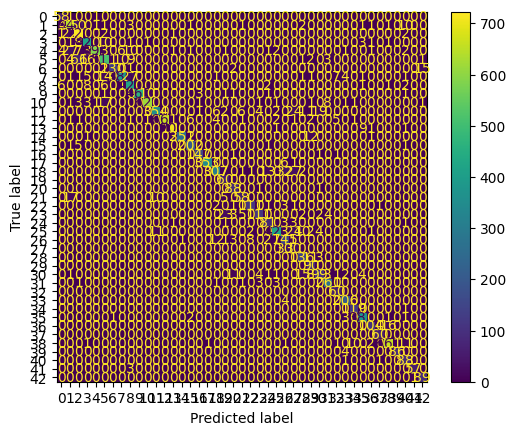

Évaluation du modèle: Random_Forest
Accuracy: 0.9213
Precision: 0.8882
Recall (Sensitivité): 0.9072
F1-score: 0.8945
Spécificité: 0.8882
IoU: 0.8221

Classification report for model Random_Forest:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        60
           1       0.87      0.91      0.89       720
           2       0.89      0.92      0.91       750
           3       0.87      0.95      0.91       450
           4       0.99      0.91      0.95       660
           5       0.90      0.88      0.89       630
           6       0.97      0.93      0.95       150
           7       0.94      0.87      0.90       450
           8       0.92      0.92      0.92       450
           9       0.98      0.97      0.98       480
          10       0.98      0.95      0.96       660
          11       0.94      0.91      0.92       420
          12       0.97      0.98      0.98       690
          13       0.99      0.99      0.99   

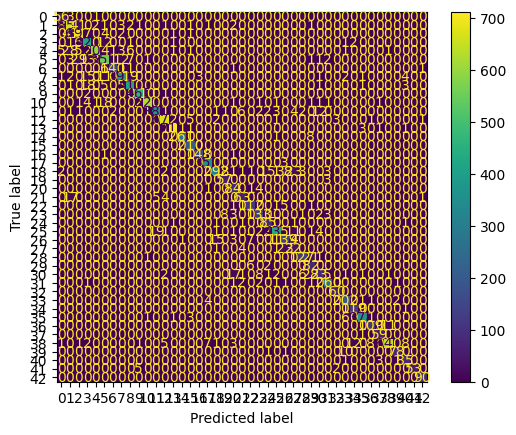

Évaluation du modèle: SVM
Accuracy: 0.9264
Precision: 0.8949
Recall (Sensitivité): 0.9183
F1-score: 0.9034
Spécificité: 0.8949
IoU: 0.8363

Classification report for model SVM:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        60
           1       0.90      0.90      0.90       720
           2       0.85      0.94      0.89       750
           3       0.95      0.94      0.95       450
           4       0.99      0.91      0.94       660
           5       0.88      0.84      0.86       630
           6       0.97      0.97      0.97       150
           7       0.96      0.90      0.93       450
           8       0.89      0.97      0.93       450
           9       0.99      0.97      0.98       480
          10       0.98      0.94      0.96       660
          11       0.89      0.94      0.92       420
          12       0.98      0.97      0.98       690
          13       0.99      0.99      0.99       720
          14

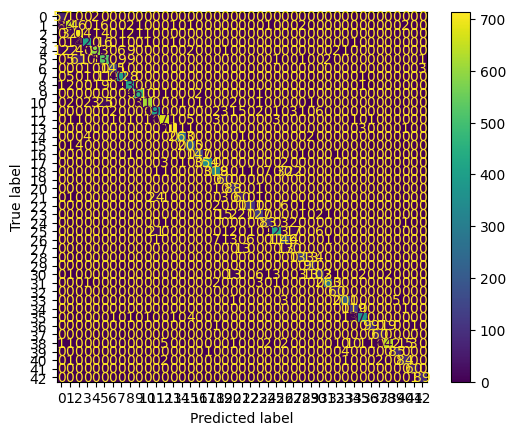

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved models and reports to disk


In [32]:
def evaluate_model(model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    tn = np.diag(cm)
    fp = cm.sum(axis=0) - tn
    fn = cm.sum(axis=1) - tn
    tp = tn
    specificity = tn / (tn + fp)
    specificity = np.mean(specificity)
    iou = tp / (tp + fp + fn)
    iou = np.mean(iou)

    print(f"Évaluation du modèle: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivité): {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Spécificité: {specificity:.4f}")
    print(f"IoU: {iou:.4f}")
    print("")

    cr = classification_report(y_test, y_pred)
    print(f"Classification report for model {model_name}:\n{cr}\n")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # Sauvegarder le rapport de classification et la matrice de confusion
    joblib.dump(cr, f'report_{model_name}.pkl')
    joblib.dump(cm, f'cm_{model_name}.pkl')

# Évaluation des modèles
evaluate_model("CNN", y_test, y_pred_cnn_classes)
evaluate_model("Random_Forest", y_test, y_pred_rf)
evaluate_model("SVM", y_test, y_pred_svm)

# Télécharger le rapport de classification et la matrice de confusion
files.download('report_CNN.pkl')
files.download('cm_CNN.pkl')
files.download('report_Random_Forest.pkl')
files.download('cm_Random_Forest.pkl')
files.download('report_SVM.pkl')
files.download('cm_SVM.pkl')

print("Saved models and reports to disk")



# 5 - Interface utilisateur

# 6 - Evaluation par les pairs

Cf. moodle
